<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/Eksperiment%20Split%20Data%20/90%3A10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from keras.applications import ResNet50

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
dataset_dir = "/content/drive/MyDrive/Skripsi Syafirna/Program/Data Sample 10"

print(os.listdir(dataset_dir))

['Common_Rust', 'Blight', 'Healthy', 'Gray_Leaf_Spot']


In [22]:
size_resnet50 = 224

In [23]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size_resnet50, size_resnet50))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [24]:
X = []
Z = []

In [25]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 114/114 [00:09<00:00, 11.58it/s]


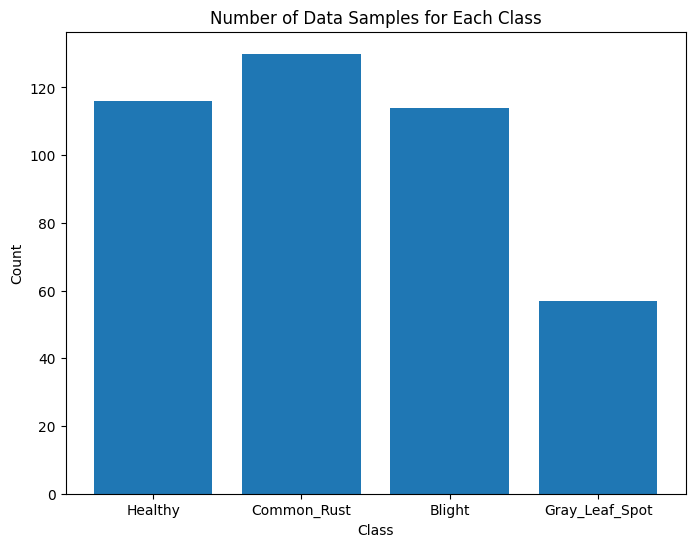

In [26]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [46]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 375
Jumlah Data Test adalah : 42


In [32]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(size_resnet50, size_resnet50, 3))

# Membuat model Sequential
model_resnet50ver2 = Sequential()
model_resnet50ver2.add(resnet50)
model_resnet50ver2.add(GlobalAveragePooling2D())
model_resnet50ver2.add(Dense(4, activation='softmax'))

# Membekukan layer-layer ResNet50 yang telah dilatih
for layer in resnet50.layers:
    layer.trainable = False

# Mengompilasi model dengan optimizer Adam dan loss function categorical crossentropy
model_resnet50ver2.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan summary dari model
model_resnet50ver2.summary()

# Melatih model dengan data latih dan validasi
history_resnet50ver2 = model_resnet50ver2.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/200
12/12 [==============================] - 6s 237ms/step - loss: 2.1819 - accuracy: 0.1200 - val_loss: 2.5054 - val_accuracy: 0.1429
Epoch 2/200
12/12 [==============================] - 1s 106ms/ste

2/2 [==============================] - 0s 119ms/step


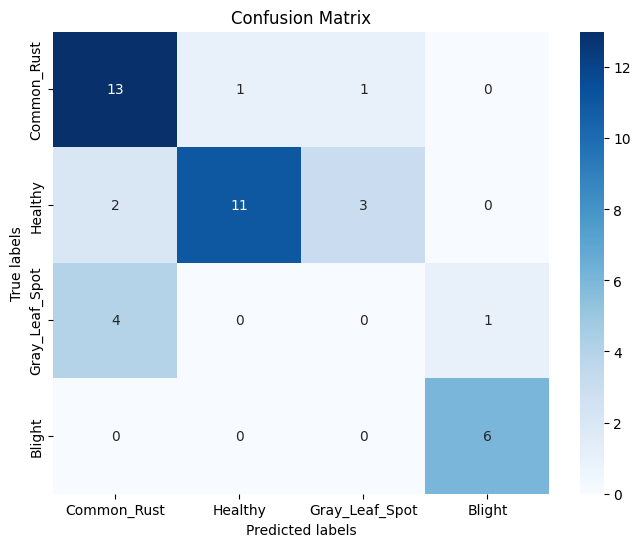


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.92      0.69      0.79        16
           2       0.00      0.00      0.00         5
           3       0.86      1.00      0.92         6

    accuracy                           0.71        42
   macro avg       0.61      0.64      0.62        42
weighted avg       0.72      0.71      0.70        42



In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Menggunakan model_resnet50ver2 untuk membuat prediksi pada data uji
Y_pred = model_resnet50ver2.predict(X_test)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai prediksi
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Mengambil indeks kelas dengan probabilitas tertinggi sebagai label sebenarnya
Y_true = np.argmax(Y_test, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Menampilkan confusion matrix dalam bentuk visualisasi
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Membuat classification report
class_report = classification_report(Y_true, Y_pred_classes)

# Menampilkan classification report
print("\nClassification Report:")
print(class_report)


In [37]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Create train and validation generators
train_generator = datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    subset='training'
)

validation_generator = datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    subset='validation'
)

# Train the model
history_resnet50ver2 = model_resnet50ver2.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator
)

Epoch 1/200
11/11 [==============================] - 4s 398ms/step - loss: 1.5719 - accuracy: 0.2959 - val_loss: 1.4127 - val_accuracy: 0.3784
Epoch 2/200
11/11 [==============================] - 6s 548ms/step - loss: 1.5182 - accuracy: 0.2959 - val_loss: 1.3827 - val_accuracy: 0.3784
Epoch 3/200
11/11 [==============================] - 4s 413ms/step - loss: 1.4760 - accuracy: 0.2959 - val_loss: 1.3596 - val_accuracy: 0.3784
Epoch 4/200
11/11 [==============================] - 5s 523ms/step - loss: 1.4463 - accuracy: 0.2959 - val_loss: 1.3405 - val_accuracy: 0.3784
Epoch 5/200
11/11 [==============================] - 4s 396ms/step - loss: 1.4209 - accuracy: 0.2959 - val_loss: 1.3332 - val_accuracy: 0.3784
Epoch 6/200
11/11 [==============================] - 6s 545ms/step - loss: 1.4051 - accuracy: 0.2959 - val_loss: 1.3233 - val_accuracy: 0.3784
Epoch 7/200
11/11 [==============================] - 4s 393ms/step - loss: 1.3899 - accuracy: 0.2959 - val_loss: 1.3224 - val_accuracy: 0.3784

2/2 [==============================] - 0s 122ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.93      0.74        15
           1       1.00      0.62      0.77        16
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00         6

    accuracy                           0.71        42
   macro avg       0.65      0.64      0.63        42
weighted avg       0.74      0.71      0.70        42



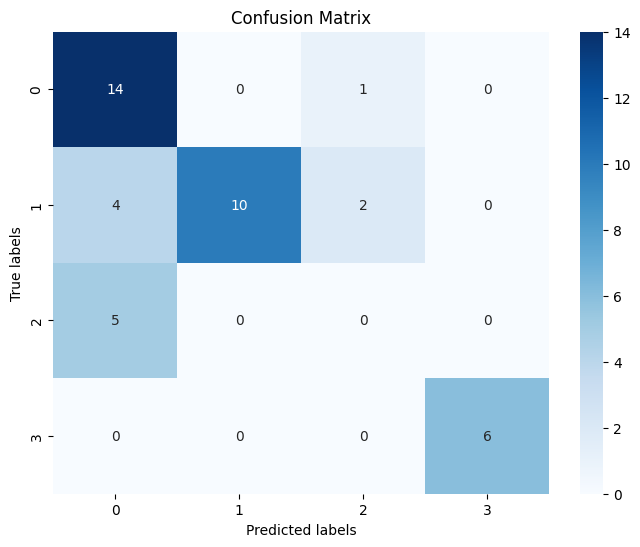

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi menggunakan model terlatih pada data uji
Y_pred = model_resnet50ver2.predict(X_test)

# Konversi prediksi dan label uji ke format yang sesuai
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Buat classification report
report = classification_report(Y_true, Y_pred_classes)
print("Classification Report:\n", report)

# Buat confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Tampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()